# Permutation test for paired data

We first look at the case of paired data - data in which we wish to compare two groups and each datapoint in one group has a counterpart in the other

Experimental designs using paired data include matched pairs (eg brothers and sisters) and repeated measures (measurements of the same individual before- and after- an intervention, or on- and off-drug).


### Set up Python libraries

As usual, run the code cell below to import the relevant Python libraries

In [1]:
# Set-up Python libraries - you need to run this but you don't need to change it
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas 
import seaborn as sns

## Colab users

You need to use a more recent version of scipy.stats than the default. To do this run the following code block and *after* it has run, go to the menus at the top of colab and click `runtime-->Restart Runtime`

In [2]:
# Set-up Python libraries - you need to run this but you don't need to change it
!pip install scipy==1.10.0
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas 
import seaborn as sns

## Toy example

[A toy example is an example with a very small dataset, just to show how it works]

We are interested in whether men or women own more pairs of socks. We decide on a matched pairs design in which husbands are compared to their wives, as it is hypothesised that lifestyle factors such as the size of the home in which people live and the duration of holidays taken will affect the number of pairs that can be reasonably justified, and these lifestyle factors are generally shared by both members of a married couple.

We obtain sock-counts for the following informal sample of 10 couples:

In [3]:
socks = pandas.DataFrame(data=[[10,12],[17,13],[48,20],[28,25],[23,18],[16,14],[18,13],[34,26],[27,22],[22,14]], columns=['Husband','Wife'])
socks

,Husband,Wife
0,10,12
1,17,13
2,48,20
3,28,25
4,23,18
5,16,14
6,18,13
7,34,26
8,27,22
9,22,14


Let's plot those data. For paired data a scatter plot is often a good choice, but actually for this tiny dataset, I prefer showing the pairs using a plot like that shown on the right:

<ul>
    <li> Why do I prefer the plot on the right? We are going to be interested in whether husbands have more socks than their wives or vice versa - I think this can be very clearly seen in the plot on the right (by inspecting whether the lines slope up or downwards) - however if there were 1000 couples in the sample rather than 10 this plot would be too crowded and hard to inspect
</ul>

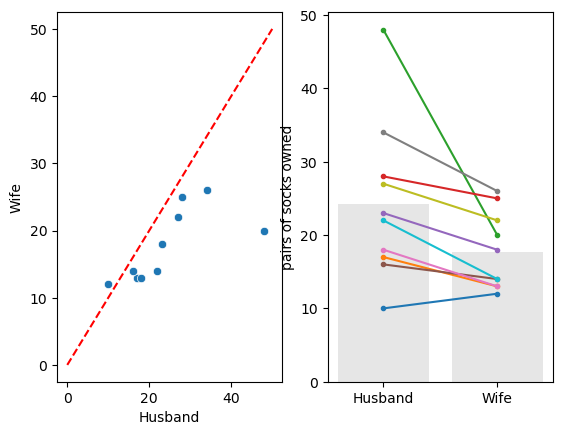

In [4]:
# Plotting code - don't get sidetracked by this, it's not that important

plt.subplot(1,2,1)
sns.scatterplot(data=socks, x='Husband', y='Wife')
plt.plot([0,50],[0,50],'r--') # add the line x=y for comparison


plt.subplot(1,2,2)
sns.barplot(data=socks, ci=None, color=[0.9,0.9,0.9]) # ci=None switches off errorbars
for i in range(len(socks)):
    plt.plot([0,1], [socks.Husband[i], socks.Wife[i]], '.-')
    plt.xticks([0,1], labels=['Husband','Wife'])
plt.ylabel('pairs of socks owned')
plt.tight_layout
plt.show()

We can see that there is one couple in which the wife owns more socks and nine in which the husband owns more.
We also note that there is one couple in which the husband has an extreme number of socks.

What is the mean difference in number of pairs of socks for [husband - wife]?

In [5]:
np.mean(socks.Husband-socks.Wife)

6.6

On average, the husbands own 6.6 more pairs of socks than their wives (but this will be skewed by the man with 48 pairs of socks).

### Is this result statistically significant? 

That is, would the result (on average husbands own 6.6 more pairs of socks) be very unlikely to occur due to chance, if the null hypothesis were true, ie if there were no sex differences in the number of pairs of socks owned? 

To answer this question, we need to know what values for the mean difference in number of pairs of socks for [husband - wife] we would get due to chance - if actually all the people (male and female) were drawn from some distribution where the number of socks they owned does not depend on their sex. 

If we drew lots of samples of 10 couples from that sock-owning population, even though there is no overall difference in sock ownership between men and women (and therefore between husbands and their wives), nonetheless we would almost always get some difference between the husbands and their wives due to random chance. The distribution of these differences is called the <b>null distribution</b> of difference of means, that is, it is <b>the distribution we would expect to obtain if the null hypothesis were true</b>.

### Obtaining the null distribution by permutation testing

In previous weeks we have obtained simulated distributions of statistics such as the sample mean, by drawing many samples from a (known) parent population (as in the exercises on the Central Limit Theorem) or by bootstrapping. Here we will attempt to do something similar.

We don't have access to the parent population, only the sample of 10 couples. The sample tells us several interesting things about the parent distribution, regardless of sex effects:
<ul>
    <li> for most couples there is a small difference in the number of pairs of socks owned
    <li> for some couples there is a large difference, driven by one member having way more socks than one can imagine needing
        <ul><li> ie the distriution of differences has positive skew </ul>
    <li> husbands with lots of socks tend to have wives with lots of socks 
        <ul><li> ie there is a correlation in number of socks between husbands and wives) </ul>
</ul>

It also tells us about some potential sex effects:
<ul>
    <li> in most couples the husband has more socks
    <li> the outlier individuals with loads of socks tend to be male
</ul>

What we are going to do is shuffle the data around to create many new (re)samples preserving the non-sex-related information but ignoring the sex of the sock owner. Using these simulated (shuffled) datasets we will work out how often we get a mean difference of 3.8 or more pairs of socks between husbands and wives, thus determining how likely our difference is to have occurred due to chance.


### Run the simulation

To generate new simulated datasets, we will shuffle around the datapoints in our original dataset. 

Which ones can we shuffle?

<ul>
<li>We assume there are no sex differences, so we can swap men for women
<li>We assume that it *does* matters which family you are in (high-sock men tend to have high-sock wives), therefore we cannot swap people between couples.
</ul>

Therefore, the only shuffling that we are allowed is to swap the labels 'Husband' and 'Wife' within couples. 
To generate each new simulated dataset, we will randomly decide whether each couple from the original dataset gets flipped.

In [6]:
socks_shuffled = socks.copy()  # work on a copy of the original dataframe
for i in range(len(socks_shuffled)):
    if np.random.rand()>0.5: # generate a random number between 0 and 1 - if it is more than 0.5:
        socks_shuffled.loc[i,'Husband'] = socks.loc[i,'Wife'] # flip number of socks for husband and wife
        socks_shuffled.loc[i,'Wife'] = socks.loc[i,'Husband'] # flip number of socks for husband and wife
    #else:
        # don't shuffle the row!
socks_shuffled

,Husband,Wife
0,12,10
1,17,13
2,48,20
3,28,25
4,18,23
5,16,14
6,13,18
7,26,34
8,22,27
9,22,14


#### What?

The above might be clearer in an example where the flips are easier to see.

Try running the code block below a few times and keep an eye on how the dataframe changes - note that in the original dataframe the man always has an odd number of pairs of socks.

In [7]:
df = pandas.DataFrame(data=[[1,2],[3,4],[5,6]], columns=['Husband','Wife'])

df_shuffled = df.copy()  # work on a copy of the original dataframe
for i in range(len(df)):
    if np.random.rand()>0.5: # generate a random number between 0 and 1 - if it is more than 0.5:
        df_shuffled.loc[i,'Husband'] = df.loc[i,'Wife'] # flip number of socks for husband and wife
        df_shuffled.loc[i,'Wife'] = df.loc[i,'Husband'] # flip number of socks for husband and wife
    #else:
        # don't shuffle the row!
df_shuffled

,Husband,Wife
0,2,1
1,3,4
2,6,5


### Visualizing randoms shuffles in the sock data

Back to our 'real' sock data

Let's see how the distribution of differences changes over a few random shuffles.

Below I generate 4 random shuffles of our sock data (in which some husbands and wives are randomly flipped), and plot the outcomes:

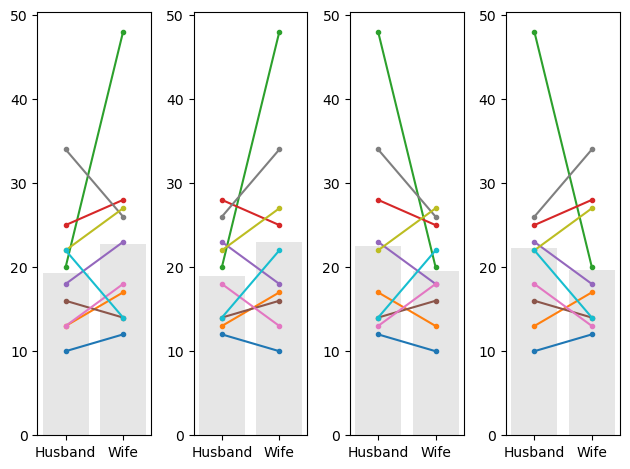

In [8]:
for n in range(4):
    socks_shuffled = socks.copy()  # work on a copy of the original dataframe
    for i in range(len(socks)):
        if np.random.rand()>0.5: # generate a random number between 0 and 1 - if it is more than 0.5:
            socks_shuffled.loc[i,'Husband'] = socks.loc[i,'Wife'] # flip number of socks for husband and wife
            socks_shuffled.loc[i,'Wife'] = socks.loc[i,'Husband'] # flip number of socks for husband and wife
        #else:
        # don't shuffle the row!
    socks_shuffled
    
    plt.subplot(1,4,n+1)
    sns.barplot(data=socks_shuffled, ci=None, color=[0.9,0.9,0.9]) # ci=None switches off errorbars
    for i in range(len(socks)):
        plt.plot([0,1], [socks_shuffled.Husband[i], socks_shuffled.Wife[i]], '.-')
        plt.xticks([0,1], labels=['Husband','Wife'])
plt.tight_layout()
plt.show()

We note that:
    
<ul>
    <li> Different couples are randomly flipped in different simulated datasets (shuffles - look which colour=ed lines have reversed their slope)
    <li> It matters a lot whether the couples with a big disparity were flipped - you can get a sense of this by looking at the grey bars which show the mean number of socks for men and women
</ul>

### Obtain the summary statistic of interest

We are interested in the mean difference in pairs of socks owned [husband-wife]. For each shuffle this is obtained as follows:

In [9]:
mDiff = np.mean(socks_shuffled.Husband - socks_shuffled.Wife)
print('mean difference for the last shuffle = ' + str(mDiff))

mean difference for the last shuffle = 2.6


### Plot the null distribution for a large number of shuffles

Now we can repeat the process for a large number of shuffles and get the mean difference in pairs of socks owned [husband-wife] for each shuffle. The distribution of these difference is the null distribution to which our observed difference (husbands own 6.6 more pairs) is to be compared.

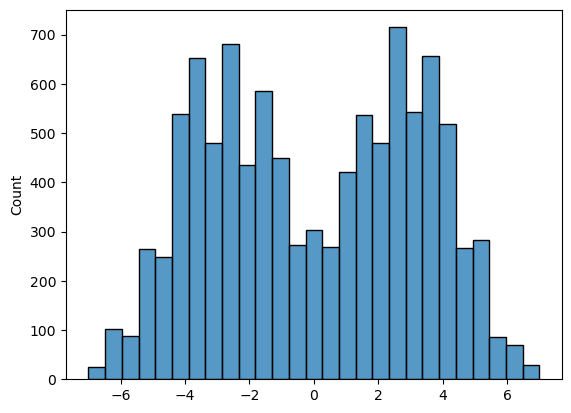

proportion >6.6 = 0.09%


In [10]:
nReps = 10000 # (number of shuffles)
mDiff = np.empty(nReps) # array to store mean difference for each shuffle

for j in range(nReps):
    socks_shuffled = socks.copy()  # work on a copy of the original dataframe
    for i in range(len(socks)):
        if np.random.rand()>0.5: # generate a random number between 0 and 1 - if it is more than 0.5:
            socks_shuffled.loc[i,'Husband'] = socks.loc[i,'Wife'] # flip number of socks for husband and wife
            socks_shuffled.loc[i,'Wife'] = socks.loc[i,'Husband'] # flip number of socks for husband and wife
        #else:
        # don't shuffle the row!
    mDiff[j] = np.mean(socks_shuffled.Husband - socks_shuffled.Wife)
    
sns.histplot(mDiff)
plt.show()

print('proportion >6.6 = ' + str(100*np.mean(mDiff>6.6)) + '%')

We can see that the null distribution for the mean difference in socks owned between husbands and wives is a bit bimodal. This is probably due to the large influence of outliers (points to the right of the plot above are probably those where the two high-sock individuals were assigned to be husbands; points to the left are probably cases where the two high-sock individuals were assiged to be wives)

### The $p$ value

We can also calculate the proportion of cases in which the mean difference in socks owned for [Husband-Wife] exceeds the value we observed in our original sample, 6.6. This proportion is about 0.06% (it will actually vary on each run of the permutation test as the permutations are random - but hopefully not much). It tells us that if we simulate a situation in which sex does not determine the number of socks owned (but preserving some other important features of the dataset like the high skew, and the correlation between husabnds and their wives), there is only a 0.06% chance that we would get an apparent sex difference as large as the one we observed in our 'real' data.

The probability that the test statistic (in this case, the mean difference in pairs of socks owned) would be observed if the null hypothesis were true, is sometimes called the <b><i>$p$-value</i></b>. 

Our permutation test shows that the $p$-value associated with the observed difference of means is 0.0006.

The result is considered statistically significant if $p$ is smaller than some predetermined level, known as $\alpha$. Usually $\alpha = 0.05$ or $\alpha = 0.01$ is used, so the result is significant if $p<0.05$ or $p<0.01$. Our result is therefore statistically significant.

## Use a built in function

Now you have seen how the permutation test works, we can learn how to run it more easily using the built in function <tt>scipy.stats.permutation_test</tt>

<b>Note-</b> For those NOT using colab - You need scipy stats version > 1.8.0 to run this. You may need to check your version by running the following code block.

In [11]:
import scipy as scipy
scipy.version.version

'1.10.0'

If this is less than 1.8.0 you need to update it - see the technical note in the first page of this chapter

For those who are using Colab - check you followed the instructions at the top of this page

### Syntax of <tt>stats.permutation_test</tt>

Here is how we run the permutation test (same as the one we did with our own code above, although note how much more quickly this one runs!)

In [12]:
def mDiff(x, y):
    return np.mean(x-y)

stats.permutation_test((socks.Husband, socks.Wife), mDiff, permutation_type='samples', alternative='two-sided', n_resamples=10000)

PermutationTestResult(statistic=6.6, pvalue=0.005859375, null_distribution=array([ 6.6,  5. ,  5.6, ..., -5.6, -5. , -6.6]))

Firstly, to reassure you this is doing a very similar job to our home-made code, check the p-value (should be about 0.06). 

We can also plot the null distribution, which hopefully looks similar to what we got from the home-made code:

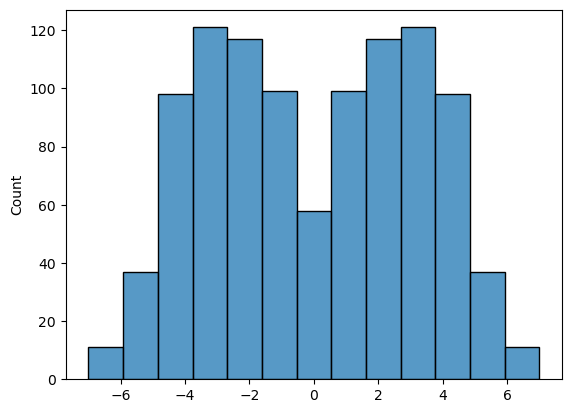

In [13]:
res = stats.permutation_test((socks.Husband, socks.Wife), mDiff, permutation_type='samples', alternative='two-sided', n_resamples=10000)
sns.histplot(res.null_distribution)
plt.show()

However, the syntax may be a bit unfamiliar.

Firstly, we had to give the function <tt>stats.permutation_test</tt> our two samples <tt>(socks.Husband, socks.Wife)</tt> as a pair of <b>series</b> (individual columns from the dataframe), rather than giving it the whole pandas dataframe as we do for many other stats functions.

Secondly, to tell <tt>stats.permutation_test</tt> the test statistic we want to get the null distribution of, we had to pass it a <i>function</i> called <tt>mDiff</tt>, and this function had to have the property that it takes in two series <tt>(socks.Husband, socks.Wife)</tt> and returns a single number <tt>mean(socks.Husband, socks.Wife)</tt>

### Defining a function

You will have come across this in datacamp but we haven't used it since. Don't be scared! It's unfamiliar but quite handy. On the other hand for a pairwise permutation test, the function I have given you for mDiff is always going to work, so if in doubt you can just copy it :-)

A function is a little computer programme that takes in some information (in this case, it takes in two series, <tt>(socks.Husband, socks.Wife)</tt> and returns some value (in this case the mean difference <tt>mean(socks.Husband, socks.Wife)</tt>

In [14]:
# define a function
def mDiff(x, y):
    return np.mean(x-y)

# run the function for some inputs
mDiff(socks.Husband, socks.Wife)

6.6

Here's another example:

In [15]:
# definte a new function that divides one element of each pair by the other, and then adds up the result across pairs
def bananas(x,y):
    return sum(x/y)

cats = np.array([1,2,3]) # one input array - have given it an arbitrary name
dogs = np.array([10,20,30]) # another input array - have given it an arbitrary name

bananas(cats,dogs)

0.30000000000000004

Now we can see how we could run <tt>stats.permutation_test</tt> on our function <tt>bananas</tt> and our data <tt>cats</tt> and <tt>dogs</tt>

In [16]:
stats.permutation_test((cats, dogs), bananas, permutation_type='samples', alternative='two-sided', n_resamples=10000)

PermutationTestResult(statistic=0.30000000000000004, pvalue=0.25, null_distribution=array([ 0.3, 10.2, 10.2, 20.1, 10.2, 20.1, 20.1, 30. ]))

## Recap

To run a permutation test on paired data, we randomly flipped some of the pairs so that the husband's sock count was assigned to the wife and vice versa. We did NOT move people between couples, as we want to retain the characteristic of the original dataset that high-sock husbands tend to have high-sock wives

For each shuffle we calculated the mean (pairwise) difference in the number of socks - husband-wife. 

Permutation testing in this way gives us a null distribution for the mean difference. Values of mean difference that occur rarely in the null distribution are considered statistically significant.
    
To run the permutation test with <tt>scipy.stats</tt> we need the option `permutation_type='samples'`